# Flowlines Extraction
Extract velocity data at the locations of flowlines and save to CSV.

This notebook extracts velocity data at the location of flowlines (from [Felikson et al.](https://doi.org/10.1029/2020GL090112)). Instead of considering every point on the glacier, only take points from flowlines for faster processing.

---

## 1. Load packages and open datasets

In [100]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
import panel
panel.extension()

In [93]:
ziFlowlines = gpd.read_file('../data/raw/flowlines/glacier0115.shp')
ziVelSeries = xr.open_dataset('../data/clean/Filtered_ZachariaeIsstromVelocitySeries.nc')

### 1.1 Print and plot data for visual analysis

In [94]:
ziFlowlines

,flowline,geometry
0,03,"LINESTRING (497822.495 -1100444.834, 497572.49..."
1,04,"LINESTRING (498154.637 -1098438.063, 497904.63..."
2,05,"LINESTRING (496710.341 -1096994.329, 496460.34..."
3,06,"LINESTRING (496475.023 -1095140.529, 496225.02..."
4,07,"LINESTRING (495177.218 -1093630.355, 494927.21..."
5,08,"LINESTRING (492086.096 -1093189.529, 491836.09..."


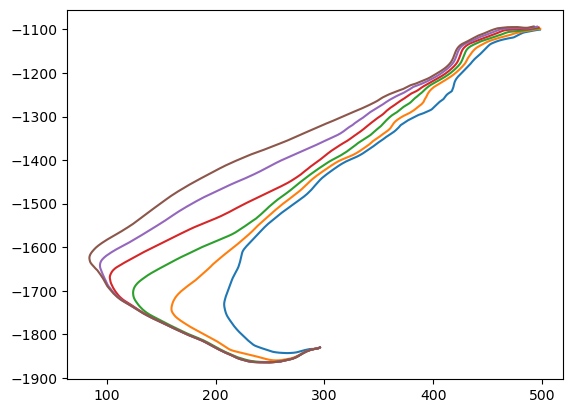

In [95]:
# Convert the flowline data from m to km
ziFlowlines['geometry_km'] = ziFlowlines['geometry'].apply(lambda geom: geom.xy)
ziFlowlines['geometry_km'] = ziFlowlines['geometry_km'].apply(lambda xy: (np.array(xy[0]) / 1000, np.array(xy[1]) / 1000))

# Plot the flowlines
for flowline_km in ziFlowlines['geometry_km']:
    plt.plot(flowline_km[0], flowline_km[1])

In [96]:
ziVelSeries

<xarray.Dataset> Size: 10kB
Dimensions:           (time: 425, x: 301, y: 301)
Coordinates:
    band              <U2 8B ...
  * x                 (x) float64 2kB 4.4e+05 4.402e+05 ... 4.998e+05 5e+05
    epsg              int64 8B ...
    name              <U4 16B ...
    _FillValue        float64 8B ...
  * y                 (y) float64 2kB -1.08e+06 -1.08e+06 ... -1.14e+06
  * time              (time) datetime64[ns] 3kB 2015-01-30T12:00:00 ... 2024-...
Data variables:
    cleaned_velocity  (time) float32 2kB ...

## 2. Convert linestrings to arrays of x and y points

Here we convert the flowlines to numpy arrays. Then, we select the flowline's (x, y) points from the overall dataset by interpolation and add these values to a new dataset. The new dataset, `combined_flowline_velocity_ds` contains the time series values for each flowline.

In [173]:
data = []

# Loop over each flowline in ziFlowlines.geometry
for flowline_id, flowline in enumerate(ziFlowlines.geometry):
    # Extract x and y coordinates for the current flowline
    x_coords = ziFlowlines['geometry_km'][flowline_id][0]  # Assuming x coordinates are in the first element
    y_coords = ziFlowlines['geometry_km'][flowline_id][1]  # Assuming y coordinates are in the second element

    # Interpolate velocity values at each point along the flowline for every timestep
    for t in ziVelSeries.time:
        # Loop over each (x, y) pair
        for idx, (x, y) in enumerate(zip(x_coords, y_coords)):
            # Direct indexing using x, y, time to grab the velocity value at each point
            # Assuming 'cleaned_velocity' is the variable name for velocity in ziVelSeries
            velocity = ziVelSeries.sel(time=t, x=x, y=y, method='nearest')["cleaned_velocity"].values
            
            # Append to data
            data.append({
                'time': t.values,
                'flowline_id': flowline_id,
                'point_index': idx,
                'x': x,
                'y': y,
                'velocity': velocity
            })

# Convert to DataFrame
velocity_df = pd.DataFrame(data)

# Display the DataFrame
print(velocity_df)

KeyboardInterrupt: 

In [ ]:
# Assuming `ziVelSeries` is the dataset with dimensions (time, x, y) 
# and `ziFlowlines.geometry` contains multiple flowlines

# Initialize a list to store the interpolated datasets for each flowline
flowline_datasets = []

# Loop over each flowline in ziFlowlines.geometry
for i, line in enumerate(iterable=ziFlowlines.geometry):
    # Extract x and y coordinates for the current flowline
    flowline_x = np.array([pt[0] for pt in ziFlowlines['geometry_km'][i]])
    x_points = []
    for pt in ziFlowlines['geometry_km'][i][0]:
        x_points.append(pt)
    flowline_y = np.array([pt[1] for pt in ziFlowlines['geometry_km'][i]])
    y_points = []
    for pt in ziFlowlines['geometry_km'][i][1]:
        y_points.append(pt)
        
    # Grab the value at the point on the flowline
    interpolated_velocity = ziVelSeries.sel(
        x=xr.DataArray(flowline_x, dims="points"),
        y=xr.DataArray(flowline_y, dims="points"),
        method="nearest"
    )["cleaned_velocity"]

    # Create a new Dataset for the interpolated flowline data
    flowline_velocity_ds = xr.Dataset(
        {
            "velocity": interpolated_velocity
        },
        coords={
            "time": ziVelSeries.time,               # Time coordinates from original dataset
            "points": np.arange(len(flowline_x)),    # Index each point along the flowline
            "x": ("points", flowline_x),             # x-coordinates of each point
            "y": ("points", flowline_y)              # y-coordinates of each point
        },
        attrs={"flowline_id": i}  # Optional: add an attribute to label each flowline
    )
    
    # Append the dataset to the list
    flowline_datasets.append(flowline_velocity_ds)

# Combine all flowline datasets into a single xarray Dataset with a new "flowline" dimension
combined_flowline_velocity_ds = xr.concat(flowline_datasets, dim="flowline")

# Display the combined dataset structure
print(combined_flowline_velocity_ds)

<xarray.Dataset> Size: 14kB
Dimensions:     (time: 425, flowline: 6, points: 2)
Coordinates:
    band        <U2 8B 'vv'
    epsg        int64 8B 3413
    name        <U4 16B 'temp'
    _FillValue  float64 8B -1.0
  * time        (time) datetime64[ns] 3kB 2015-01-30T12:00:00 ... 2024-04-18T...
  * points      (points) int64 16B 0 1
    x           (flowline, points) float64 96B 497.8 -1.1e+03 ... -1.093e+03
    y           (flowline, points) float64 96B 497.6 -1.1e+03 ... -1.093e+03
Dimensions without coordinates: flowline
Data variables:
    velocity    (flowline, time) float32 10kB 1.136e+03 1.041e+03 ... 1.186e+03
Attributes:
    flowline_id:  0


In [150]:
ziFlowlines['geometry_km'][2][0]

array([496.71034061, 496.46034061, 496.21034061, ..., 295.73408015,
       295.65897281, 295.76505735])

In [151]:
import pandas as pd
import numpy as np

data = []
# Loop over each flowline in ziFlowlines.geometry
for flowline_id, flowline in enumerate(ziFlowlines.geometry):
    # Extract x and y coordinates for the current flowline
    x_coords = [ziFlowlines['geometry_km'][flowline_id][i]]  # Assuming x coordinates are in the first element
    y_coords = [ziFlowlines['geometry_km'][flowline_id][i]]  # Assuming y coordinates are in the second element

    # Debugging: Check the extracted coordinates
    print(f"Flowline {flowline_id}, x_coords: {x_coords}, y_coords: {y_coords}")

    # Interpolate velocity values at each point along the flowline for every timestep
    for t in ziVelSeries.time:
        # Debugging: Check the current time step
        print(f"Interpolating for time: {t}")

        # Interpolate velocities at points along the flowline
        interpolated = ziVelSeries.interp(
            x=("points", x_coords),
            y=("points", y_coords),
            time=t
        )["cleaned_velocity"].values  # Assuming velocity variable name is 'velocity'

        # Debugging: Check the result of the interpolation
        print(f"Interpolated velocities at time {t}: {interpolated}")

        # If interpolation was successful and returned an array of velocities
        if interpolated.size > 0:  # Check if interpolation result is not empty
            for point_index, velocity in enumerate(interpolated):
                # Append each x, y, velocity, time, and flowline_id as a row
                data.append({
                    'time': t.values,
                    'flowline_id': flowline_id,
                    'point_index': point_index,
                    'x': x_coords[point_index],
                    'y': y_coords[point_index],
                    'velocity': velocity
                })

# Convert to DataFrame
velocity_df = pd.DataFrame(data)

# Display the DataFrame
print(velocity_df)


Flowline 0, x_coords: [array([497.82249451, 497.57249451, 497.32249451, ..., 295.73637536,
       295.66841311, 295.75556913])], y_coords: [array([497.82249451, 497.57249451, 497.32249451, ..., 295.73637536,
       295.66841311, 295.75556913])]
Interpolating for time: <xarray.DataArray 'time' ()> Size: 8B
array('2015-01-30T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    band        <U2 8B ...
    epsg        int64 8B ...
    name        <U4 16B ...
    _FillValue  float64 8B ...
    time        datetime64[ns] 8B 2015-01-30T12:00:00


ValueError: Variable None: Could not convert tuple of form (dims, data[, attrs, encoding]): ('points', [array([497.82249451, 497.57249451, 497.32249451, ..., 295.73637536,
       295.66841311, 295.75556913])]) to Variable.

In [172]:
ziFlowlines['geometry_km'][flowline_id][0]

array([492.08609631, 491.83609631, 491.58609631, ..., 295.69149545,
       295.62966629, 295.77885025])

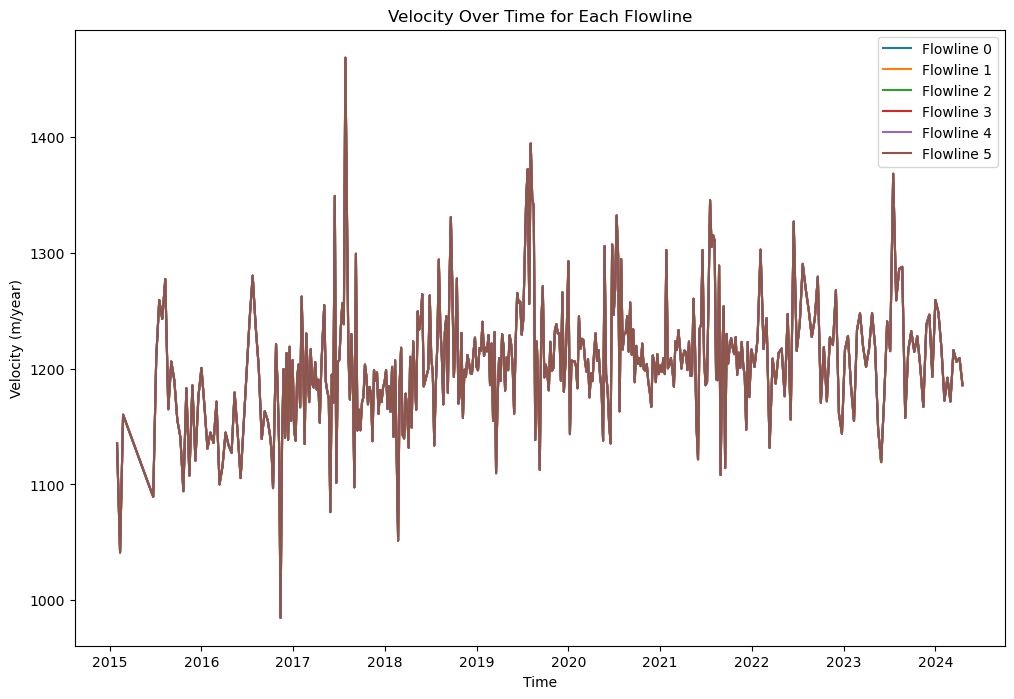

In [ ]:
# Plot the flowline data from velocity_df for each flowline
plt.figure(figsize=(12, 8))

# Loop over each flowline and plot the velocity over time
for flowline_id in velocity_df['flowline_id'].unique():
    flowline_data = velocity_df[velocity_df['flowline_id'] == flowline_id]
    plt.plot(flowline_data['time'], flowline_data['velocity'], label=f'Flowline {flowline_id}')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Velocity (m/year)')
plt.title('Velocity Over Time for Each Flowline')
plt.legend()
plt.show()

In [161]:
# Ensure the velocity column contains scalar values
velocity_df['velocity'] = velocity_df['velocity'].apply(lambda x: x.item() if isinstance(x, np.ndarray) else x)

# Check if any of the flowlines have matching values for all velocity values
flowlines_with_same_values = velocity_df.groupby('flowline_id')['velocity'].apply(lambda x: x.nunique() == 1)

# Print the result
print(flowlines_with_same_values)

flowline_id
0    False
1    False
2    False
3    False
4    False
5    False
Name: velocity, dtype: bool


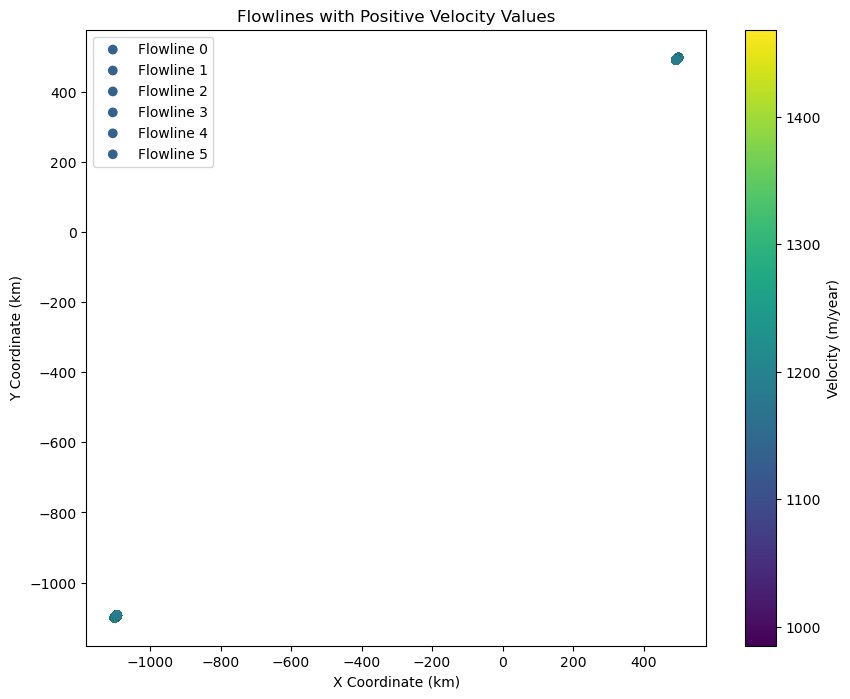

In [163]:
# Filter the dataframe to include only positive velocity values
positive_velocity_df = velocity_df[velocity_df['velocity'] > 0]

# Plot the flowlines with their associated positive velocity values in color
plt.figure(figsize=(10, 8))

# Loop over each flowline and plot the points with positive velocity values as color
for flowline_id in positive_velocity_df['flowline_id'].unique():
    flowline_data = positive_velocity_df[positive_velocity_df['flowline_id'] == flowline_id]
    x = flowline_data['x'].values
    y = flowline_data['y'].values
    velocities = flowline_data['velocity'].values
    
    # Ensure the lengths of x, y, and velocities match
    if len(x) == len(velocities):
        sc = plt.scatter(x, y, c=velocities, cmap='viridis', label=f'Flowline {flowline_id}')
    else:
        print(f"Skipping flowline {flowline_id} due to length mismatch")

# Add colorbar and labels
plt.colorbar(sc, label='Velocity (m/year)')
plt.xlabel('X Coordinate (km)')
plt.ylabel('Y Coordinate (km)')
plt.title('Flowlines with Positive Velocity Values')
plt.legend()
plt.show()

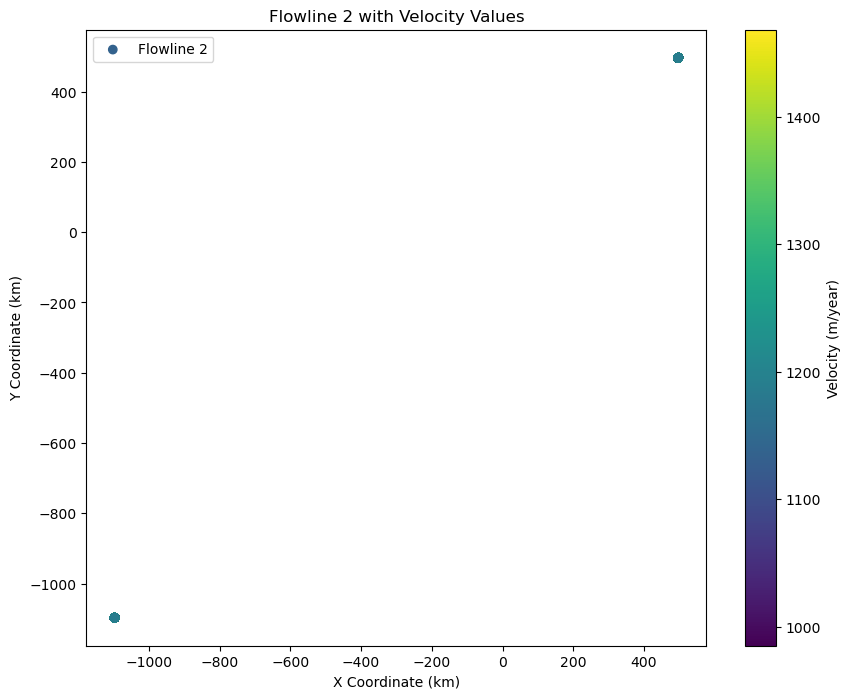

In [165]:
# Extract the x and y coordinates for flowline 2
x = velocity_df[velocity_df['flowline_id'] == 2]['x'].values
y = velocity_df[velocity_df['flowline_id'] == 2]['y'].values

# Extract the velocity values for flowline 2
velocities = velocity_df[velocity_df['flowline_id'] == 2]['velocity'].values

# Ensure the lengths of x, y, and velocities match
if len(x) == len(velocities):
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(x, y, c=velocities, cmap='viridis', label='Flowline 2')
    
    # Add colorbar and labels
    plt.colorbar(sc, label='Velocity (m/year)')
    plt.xlabel('X Coordinate (km)')
    plt.ylabel('Y Coordinate (km)')
    plt.title('Flowline 2 with Velocity Values')
    plt.legend()
    plt.show()
else:
    print("Length mismatch between coordinates and velocity values.")

In [ ]:
import numpy as np
import xarray as xr

# Example flowline velocity dataset (time, x, y dimensions)
# `flowline_velocities` - xarray dataset containing (time, x, y) velocity values

data = []

# Loop over each flowline in `ziFlowlines.geometry`
for flowline_id, flowline in enumerate(ziFlowlines.geometry):
    # Extract x and y coordinates for each point on this flowline
    x_coords = np.array([pt[0] for pt in flowline.coords])
    y_coords = np.array([pt[1] for pt in flowline.coords])
    
    # Interpolate velocity values at each point along the flowline for every timestep
    for t in ziVelSeries.time:
        # Interpolate velocities at points along the flowline
        interpolated = ziVelSeries.interp(
            x=("points", x_coords),
            y=("points", y_coords),
            time=t
        )["cleaned_velocity"].values  # Assume velocity variable name is 'velocity'
        
        # Ensure `interpolated` contains a list of velocities
        if interpolated.ndim == 1:  # if it contains an array of velocities
            for point_index, velocity in enumerate(interpolated):
                # Append each x, y, velocity, time, and flowline_id as a row
                data.append({
                    'time': t.values,
                    'flowline_id': flowline_id,
                    'point_index': point_index,
                    'x': x_coords[point_index],
                    'y': y_coords[point_index],
                    'velocity': velocity
                })

# Convert to DataFrame
velocity_df = pd.DataFrame(data)

# Display the DataFrame
print(velocity_df)


Empty DataFrame
Columns: []
Index: []


Convert the Xarray dataset to a Pandas dataframe for use with Pycaret's hyperparameter testing capabilities.

In [98]:
combined_flowline_velocity_df = combined_flowline_velocity_ds.to_dataframe().reset_index()
combined_flowline_velocity_df

,time,flowline,points,band,epsg,name,_FillValue,velocity,x,y
0,2015-01-30 12:00:00,0,0,vv,3413,temp,-1.0,1135.628052,497.822495,497.572495
1,2015-01-30 12:00:00,0,1,vv,3413,temp,-1.0,1135.628052,-1100.444834,-1100.490358
2,2015-01-30 12:00:00,1,0,vv,3413,temp,-1.0,1135.628052,498.154637,497.904637
3,2015-01-30 12:00:00,1,1,vv,3413,temp,-1.0,1135.628052,-1098.438063,-1098.497794
4,2015-01-30 12:00:00,2,0,vv,3413,temp,-1.0,1135.628052,496.710341,496.460341
...,...,...,...,...,...,...,...,...,...,...
5095,2024-04-18 12:00:00,3,1,vv,3413,temp,-1.0,1185.645996,-1095.140529,-1095.199534
5096,2024-04-18 12:00:00,4,0,vv,3413,temp,-1.0,1185.645996,495.177218,494.927218
5097,2024-04-18 12:00:00,4,1,vv,3413,temp,-1.0,1185.645996,-1093.630355,-1093.726953
5098,2024-04-18 12:00:00,5,0,vv,3413,temp,-1.0,1185.645996,492.086096,491.836096


Skipping flowline 0 due to length mismatch
Skipping flowline 1 due to length mismatch
Skipping flowline 2 due to length mismatch
Skipping flowline 3 due to length mismatch
Skipping flowline 4 due to length mismatch
Skipping flowline 5 due to length mismatch


/var/folders/z2/t78xbk451n74r4q5p4w1zt640000gn/T/ipykernel_63988/227210442.py:17: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 3 Axes> than <Figure size 1000x800 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(sc, label='Velocity (m/year)')
/var/folders/z2/t78xbk451n74r4q5p4w1zt640000gn/T/ipykernel_63988/227210442.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


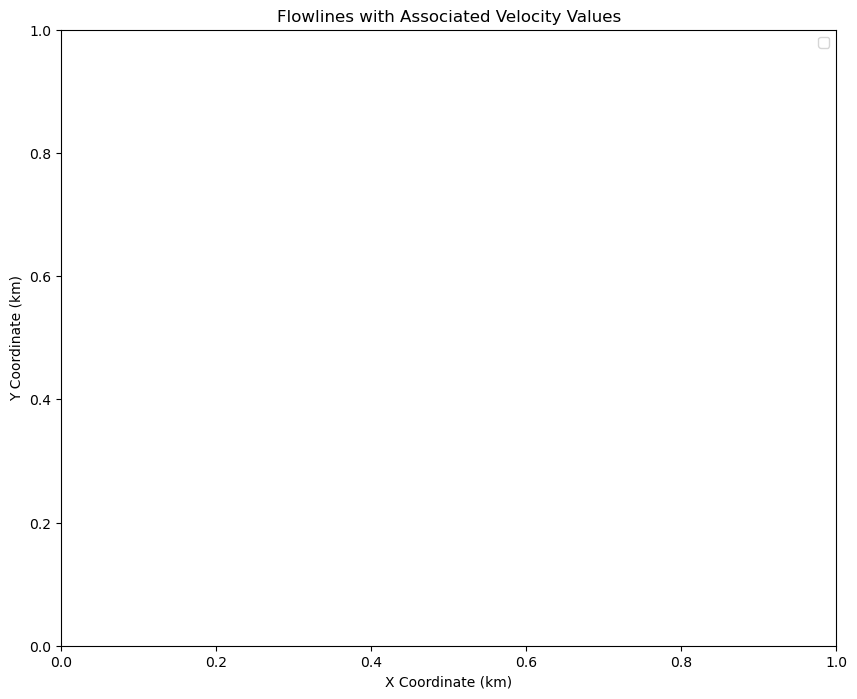

In [118]:
# Plot the flowlines with their associated velocity values in color
plt.figure(figsize=(10, 8))

# Loop over each flowline and plot the points with velocity values as color
for i, flowline in ziFlowlines.iterrows():
    x = flowline['geometry_km'][0]
    y = flowline['geometry_km'][1]
    velocities = combined_flowline_velocity_df[combined_flowline_velocity_df['flowline'] == i]['velocity'].values
    
    # Ensure the lengths of x, y, and velocities match
    if len(x) == len(velocities):
        sc = plt.scatter(x, y, c=velocities, cmap='viridis', label=f'Flowline {i}')
    else:
        print(f"Skipping flowline {i} due to length mismatch")

# Add colorbar and labels
plt.colorbar(sc, label='Velocity (m/year)')
plt.xlabel('X Coordinate (km)')
plt.ylabel('Y Coordinate (km)')
plt.title('Flowlines with Associated Velocity Values')
plt.legend()
plt.show()

In [99]:
combined_flowline_velocity_df.to_csv('../data/clean/Combined_Flowline_Velocity.csv')